In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [58]:
import gc

import pandas as pd
import numpy as np

from xgboost import plot_importance
import matplotlib.pyplot as pyplot
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# from preprocess import preprocess
# from train import train_eval_model

from load import BaseDataLoader
from packager import Packager
from feature_engineer import FeatureEngineer
from cross_val_labo import CrossValLabo
from settings import DATA_DIR

In [59]:
data = BaseDataLoader(DATA_DIR).files
trs_train = data['train_transaction']
trs_test = data['test_transaction']
del data
gc.collect()

Loaded tables' types are not converted


3129

In [60]:
train_mask, val_mask = Packager.get_train_val_masks(trs_train)

In [61]:
train = trs_train[train_mask]
val = trs_train[val_mask]
feat_cols, label_col = Packager.split_feat_label(train)
X_train = train[feat_cols]
Y_train = train[label_col]
X_val = val[feat_cols]
Y_val = val[label_col]
del train
del val
gc.collect()

0

In [62]:
skip = ['trs_amt_sin', 'trs_amt_scale', 'trs_amt_diff', 'trs_amt_round', 'trs_card_type_dum'] #, 'trs_card_type_dum'
exclude = [] #['trs_amt_scale', 'trs_amt_round']
fi = FeatureEngineer(skip, exclude)
X_train_prepro = fi.transform(X_train, 'TransactionID', 'train')
X_val_prepro = fi.transform(X_val, 'TransactionID', 'val')

step 0: trs_amt_sin
skipping
step 1: trs_amt_scale
skipping
step 2: trs_amt_diff
skipping
step 3: trs_amt_round
skipping
step 4: trs_card_type_dum
skipping
step 0: trs_amt_sin
skipping
step 1: trs_amt_scale
skipping
step 2: trs_amt_diff
skipping
step 3: trs_amt_round
skipping
step 4: trs_card_type_dum
skipping
missing card_type_charge card
missing card_type_debit or credit


In [64]:
model = XGBClassifier()
parameters = {
    'nthread':[8], #when use hyperthread, xgboost may become slower
    'objective':['binary:logistic'],
    'learning_rate': [0.04, 0.6], # from 0.1
    'max_depth': [2], # opti 20 but slow
    'min_child_weight': [100],
    'silent': [1],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8], # from 0.8
    'n_estimators': [1000], #number of trees, change it to 1000 for better results
    'seed': [1337]}

 
lgb_params = {
                'objective':'regression',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.01,
                'num_leaves': 2**4,
                'max_depth':5,
                'tree_learner':'serial',
                'colsample_bytree': 0.80,
                'subsample_freq':1,
                'subsample':1,
                'n_estimators':2**10,
                'max_bin':255,
                'verbose':-1,
                'seed': 1337,
                'early_stopping_rounds':100,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            }
print('a')
CrossValLabo.quick_lgbm(lgb_params, X_train_prepro, Y_train, X_val_prepro, Y_val)

a
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.710483	valid_1's auc: 0.686213
[400]	training's auc: 0.72397	valid_1's auc: 0.696913
Early stopping, best iteration is:
[471]	training's auc: 0.726249	valid_1's auc: 0.697525


In [47]:
best_parameters_val, score_val, score_train, model = CrossValLabo.optimize_hparams(model, parameters, X_train_prepro, Y_train, X_val_prepro, Y_val)

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] learning_rate=0.06, max_depth=3, min_child_weight=100, n_estimators=1000, nthread=8, objective=binary:logistic, seed=1337, silent=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.06, max_depth=3, min_child_weight=100, n_estimators=1000, nthread=8, objective=binary:logistic, seed=1337, silent=1, total=  52.0s
[CV] learning_rate=0.8, max_depth=3, min_child_weight=100, n_estimators=1000, nthread=8, objective=binary:logistic, seed=1337, silent=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.0s remaining:    0.0s


[CV]  learning_rate=0.8, max_depth=3, min_child_weight=100, n_estimators=1000, nthread=8, objective=binary:logistic, seed=1337, silent=1, total= 1.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished


In [48]:
print(best_parameters_val)
print(score_val)
print(score_train)

{'learning_rate': 0.06, 'max_depth': 3, 'min_child_weight': 100, 'n_estimators': 1000, 'nthread': 8, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1}
0.6967691088289812
0.7421719916212053


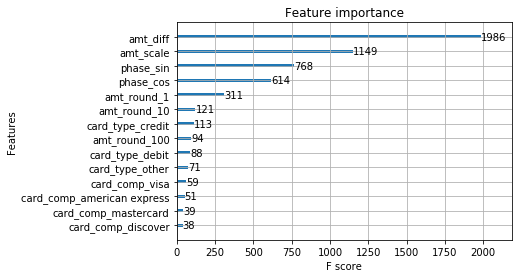

In [49]:
plot_importance(model)